In [2]:
# import sagemaker
# from sagemaker import get_execution_role

# sagemaker_session = sagemaker.Session()

# role = get_execution_role()
# region = sagemaker_session.boto_region_name

In [3]:
from importlib import reload
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import utils
import data
import os
reload(utils)

<module 'utils' from '/root/team-skin-lesions/exploration_notebooks/utils.py'>

In [11]:
data.metadata_train

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


In [12]:
data.metadata_train.describe()

,age_approx
count,24894.000000
mean,54.028481
std,18.130971
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,85.000000


In [45]:
data.metadata_train.isna().sum(axis=0)

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [14]:
# Rows with no NAs at all
(data.metadata_train.isna().sum(axis=1) == 0).sum()

21311

In [46]:
#rows with any missing data
data.metadata_train.isna().any(axis=1).sum()


4020

array([[<AxesSubplot:title={'center':'age_approx'}>]], dtype=object)

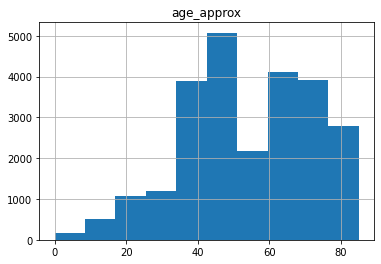

In [15]:
data.metadata_train.hist()

In [16]:
data.metadata_train.groupby("sex").count()

,image,age_approx,anatom_site_general,lesion_id
sex,,,,
female,11661,11635,10554,10810
male,13286,13259,11977,12316


In [30]:
class_sum = data.y_train.sum(axis=0)
class_sum_df = pd.DataFrame(class_sum)
class_sum_df = class_sum_df.transpose()
class_sum_df = class_sum_df.iloc[: , 1:]
class_sum_df = class_sum_df.iloc[: , :-1]
class_sum_df

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,4522.0,12875.0,3323.0,867.0,2624.0,239.0,253.0,628.0


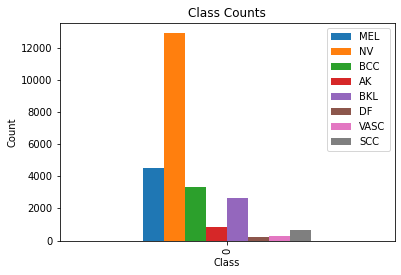

In [41]:
#Create class bar graph 
ax = class_sum_df.plot(kind = "bar")
plt.title("Class Counts")
plt.xlabel("Class")
plt.ylabel("Count");

In [25]:
#creating display of performance metrics across all models
data = {'Model': ['Log Regression', 'KNN', 'Random Forest', 'CNN', 'CNN+Optuna', 'CNN+EfficientNet', 'CNN+Optuna+EfficienNet', 'CNN+EfficientNet+Metadata', 'CNN+XGBoost'],
        'Accuracy': [0.459, 0.21, 0.207, 0.189, 0.329, 0.283, 0.26, 0.1, 0.203],
        'Precision': [0.247, 0.282, 0.243, 0.123, 0.125, 0.125, 0.12, 0.108, 0.138],
        'Recall': [0.243, 0.241, 0.181, 0.114, 0.124, 0.121, 0.118, 0.113, 0.138],
        'ROC AUC': [0.576, 0.593, 0.567, 0.476, 0.492, 0.489, 0.494, 0.522, 0.506]}  
df = pd.DataFrame(data)  
df

,Model,Accuracy,Precision,Recall,ROC AUC
0,Log Regression,0.459,0.247,0.243,0.576
1,KNN,0.210,0.282,0.241,0.593
2,Random Forest,0.207,0.243,0.181,0.567
3,CNN,0.189,0.123,0.114,0.476
4,CNN+Optuna,0.329,0.125,0.124,0.492
5,CNN+EfficientNet,0.283,0.125,0.121,0.489
6,CNN+Optuna+EfficienNet,0.260,0.120,0.118,0.494
7,CNN+EfficientNet+Metadata,0.100,0.108,0.113,0.522
8,CNN+XGBoost,0.203,0.138,0.138,0.506


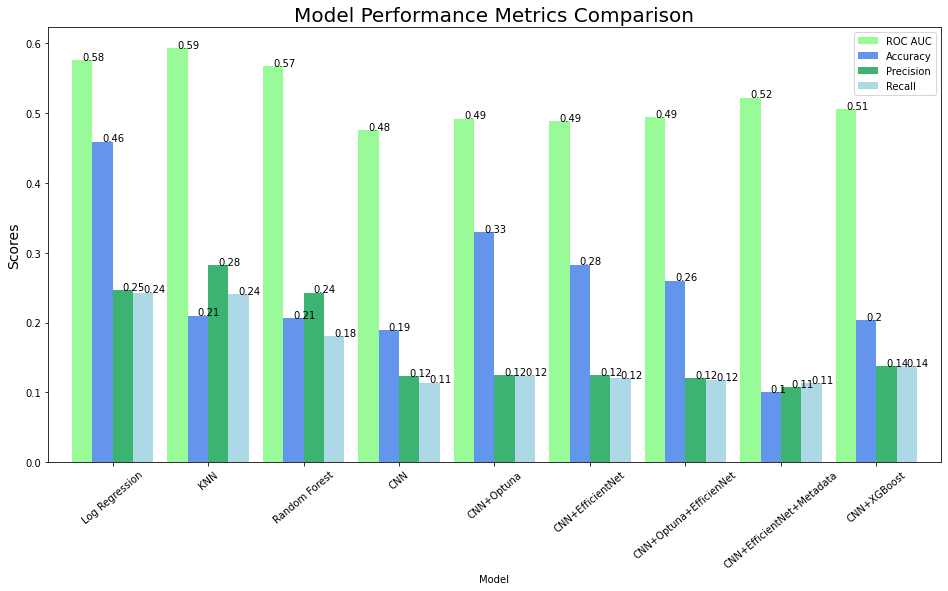

In [26]:
#creating bar chart for perfomrance
colors = ['palegreen', 'cornflowerblue', 'mediumseagreen', 'lightblue']
fig, ax = plt.subplots()
df.plot.bar(x = 'Model', y = ['ROC AUC', 'Accuracy', 'Precision', 'Recall'], rot = 40, ax = ax, color =  colors, width = .85)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))
ax.set_ylabel('Scores', fontsize = 14)
ax.set_title('Model Performance Metrics Comparison', fontsize = 20)
plt.legend(loc='upper right')
fig.set_size_inches(16, 8)
# plt.grid()

In [51]:
#creating display of ROC AUC all models
data2 = {'Model': ['Log Regression', 'KNN', 'Random Forest', 'CNN', 'CNN+Optuna', 'CNN+EfficientNet', 'CNN+Optuna+EfficienNet', 'CNN+EfficientNet+Metadata', 'CNN+XGBoost'],
        'ROC AUC': [58.6, 59.3, 56.7, 47.6, 49.2, 48.9, 49.4, 52.3, 50.6] }
df2 = pd.DataFrame(data2)  
df2

,Model,ROC AUC
0,Log Regression,58.6
1,KNN,59.3
2,Random Forest,56.7
3,CNN,47.6
4,CNN+Optuna,49.2
5,CNN+EfficientNet,48.9
6,CNN+Optuna+EfficienNet,49.4
7,CNN+EfficientNet+Metadata,52.3
8,CNN+XGBoost,50.6


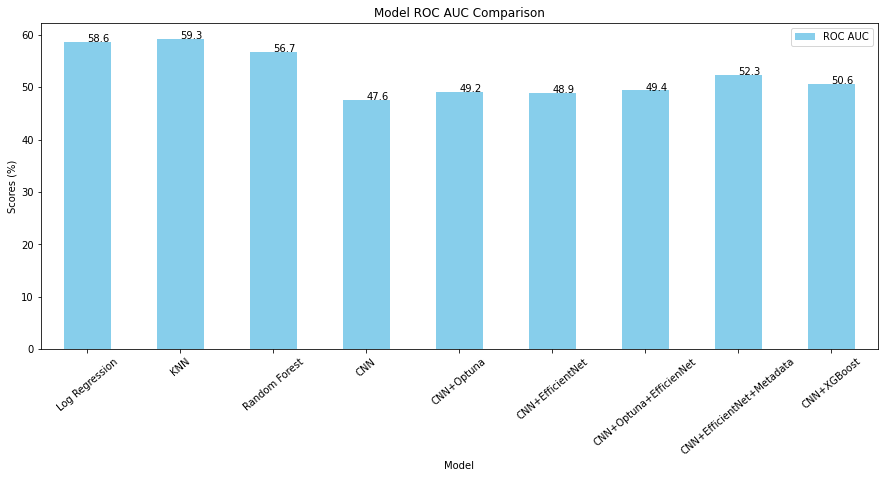

In [54]:
#creating bar chart for perfomrance
colors = ['skyblue']
fig, ax = plt.subplots()
df2.plot.bar(x = 'Model', y = ['ROC AUC'], rot = 40, ax = ax, color =  colors)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))
ax.set_ylabel('Scores (%)')
ax.set_title('Model ROC AUC Comparison')
fig.set_size_inches(15, 6)